In [12]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from linearmodels.panel import compare
from statsmodels.stats.outliers_influence import variance_inflation_factor
from linearmodels.panel import PanelOLS, RandomEffects
from scipy.stats import chi2
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

In [13]:
# Load data
file_path = '../data/CA2_filled.csv'
data = pd.read_csv(file_path)

# Data preprocessing: dependent and independent variables
# Dependent variable: log(GDP)
# Independent variables: edu_m, edu_f, gra_m, gra_f, gee, er_m, er_f, law, cpi

# Convert variables to appropriate data types (ensure correctness)
data['Country'] = data['Country'].astype('category')
data['Year'] = data['Year'].astype('int')

# Apply log transformation to gdp
data['log_gdp'] = np.log(data['gdp'])

In [14]:
data['gpi'] = data['edu_f'] / data['edu_m']

# Multicollinearity check

In [15]:
# Multicollinearity check using Variance Inflation Factor (VIF)
print("\nVariance Inflation Factor (VIF) before removing variables:")
X = data[['log_gdp', 'gee', 'er', 'law', 'cpi']].copy()
X.loc[:, 'Intercept'] = 1  # Add intercept for VIF calculation
vif_data_before = pd.DataFrame()
vif_data_before['Variable'] = X.columns
vif_data_before['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data_before)


Variance Inflation Factor (VIF) before removing variables:
    Variable         VIF
0    log_gdp    2.741991
1        gee    2.558792
2         er    1.087863
3        law    1.984679
4        cpi    1.563001
5  Intercept  235.433058


# Hausman test---choose RE model

In [16]:
# Hausman test for fixed vs. random effects
# Using linearmodels library for panel data regression
from linearmodels.panel import compare

# Fixed effects model
fixed_effects = PanelOLS.from_formula('gpi ~ log_gdp + gee + er + law + cpi + EntityEffects', data=data.set_index(['Country', 'Year'])).fit()

# Random effects model
random_effects = RandomEffects.from_formula('gpi ~ log_gdp + gee + er + law + cpi', data=data.set_index(['Country', 'Year'])).fit()

# Standard Hausman test
print("\nHausman Test:")
fe_params = fixed_effects.params
re_params = random_effects.params
common_params = fe_params.index.intersection(re_params.index)

b_diff = fe_params[common_params] - re_params[common_params]
V_fe = fixed_effects.cov.loc[common_params, common_params]
V_re = random_effects.cov.loc[common_params, common_params]
V_diff = V_fe - V_re

hausman_stat = b_diff.T @ np.linalg.inv(V_diff) @ b_diff
p_value = 1 - chi2.cdf(hausman_stat, len(common_params))

print(f"Hausman Statistic: {hausman_stat}")
print(f"P-value: {p_value}")


Hausman Test:
Hausman Statistic: 4.563291286703915
P-value: 0.47146020002363476


d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:590: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = self._frame.groupby(level=level).transform("mean")
d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:590: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = self._frame.groupby(level=level).transform("mean")
d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:680: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior o

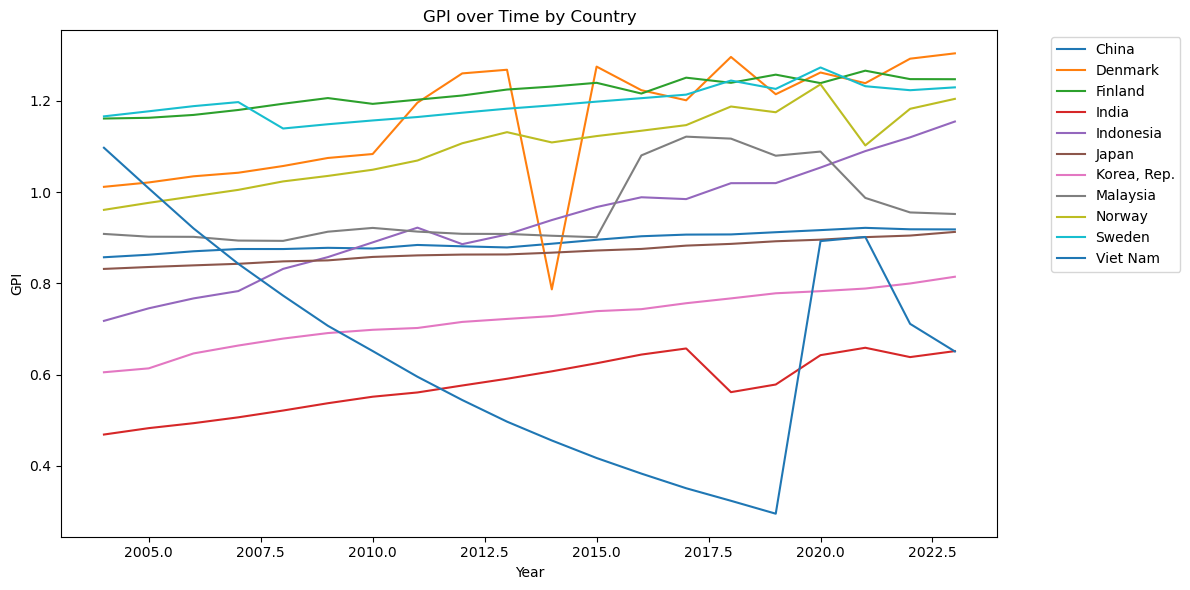

In [17]:
# Plot Gender Parity Index over time for each country using seaborn
plt.figure(figsize=(12, 6))
for country in data['Country'].unique():
    country_data = data[data['Country'] == country]
    plt.plot(country_data['Year'], country_data['gpi'], label=country)

plt.xlabel('Year')
plt.ylabel('GPI')
plt.title('GPI over Time by Country')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# without interactions

In [18]:
# Random effects regression
re_model = RandomEffects.from_formula('gpi ~ log_gdp + gee + er + law + cpi', data=data.set_index(['Country', 'Year'])).fit(cov_type='robust')
# Output the regression result
print("\nRandom Effects Regression Results:")
print(re_model.summary)


Random Effects Regression Results:
                        RandomEffects Estimation Summary                        
Dep. Variable:                    gpi   R-squared:                        0.6559
Estimator:              RandomEffects   R-squared (Between):              0.9752
No. Observations:                 220   R-squared (Within):               0.1078
Date:                Wed, Oct 23 2024   R-squared (Overall):              0.9658
Time:                        23:10:18   Log-likelihood                    201.05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      81.977
Entities:                          11   P-value                           0.0000
Avg Obs:                       20.000   Distribution:                   F(5,215)
Min Obs:                       20.000                                           
Max Obs:                       20.000   F-statistic (robust):            

d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:599: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weighted_sum: DataFrame = frame.groupby(level=level).transform("sum")
d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:601: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sum_weights: DataFrame = frame.groupby(level=level).transform("sum")
d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:599: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain cur

# with interactions

In [19]:
# Create interaction terms
data['law_er'] = data['law'] * data['er']

In [20]:
# Random effects regression
re_model = RandomEffects.from_formula('gpi ~ log_gdp + gee + er + law + cpi + law_er', data=data.set_index(['Country', 'Year'])).fit(cov_type='robust')
# Output the regression result
print("\nRandom Effects Regression Results:")
print(re_model.summary)


Random Effects Regression Results:
                        RandomEffects Estimation Summary                        
Dep. Variable:                    gpi   R-squared:                        0.8017
Estimator:              RandomEffects   R-squared (Between):              0.9873
No. Observations:                 220   R-squared (Within):               0.3364
Date:                Wed, Oct 23 2024   R-squared (Overall):              0.9802
Time:                        23:10:18   Log-likelihood                    233.59
Cov. Estimator:                Robust                                           
                                        F-statistic:                      144.16
Entities:                          11   P-value                           0.0000
Avg Obs:                       20.000   Distribution:                   F(6,214)
Min Obs:                       20.000                                           
Max Obs:                       20.000   F-statistic (robust):            

d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:599: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weighted_sum: DataFrame = frame.groupby(level=level).transform("sum")
d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:601: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sum_weights: DataFrame = frame.groupby(level=level).transform("sum")
d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:599: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain cur

# Robustness check

In [21]:
# Random effects regression with interaction term and kernel standard errors
re_model = RandomEffects.from_formula('gpi ~ log_gdp + gee + er + law + cpi + law_er', data=data.set_index(['Country', 'Year'])).fit(cov_type='kernel')
# Output the regression result
print("\nRandom Effects Regression Results with Interaction Terms and kernel Standard Errors:")
print(re_model.summary)

d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:599: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weighted_sum: DataFrame = frame.groupby(level=level).transform("sum")
d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:601: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sum_weights: DataFrame = frame.groupby(level=level).transform("sum")
d:\LeStoreDownload\anaconda\Lib\site-packages\linearmodels\panel\data.py:599: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain cur


Random Effects Regression Results with Interaction Terms and kernel Standard Errors:
                        RandomEffects Estimation Summary                        
Dep. Variable:                    gpi   R-squared:                        0.8017
Estimator:              RandomEffects   R-squared (Between):              0.9873
No. Observations:                 220   R-squared (Within):               0.3364
Date:                Wed, Oct 23 2024   R-squared (Overall):              0.9802
Time:                        23:10:19   Log-likelihood                    233.59
Cov. Estimator:        Driscoll-Kraay                                           
                                        F-statistic:                      144.16
Entities:                          11   P-value                           0.0000
Avg Obs:                       20.000   Distribution:                   F(6,214)
Min Obs:                       20.000                                           
Max Obs:               